In [1]:
from __future__ import division, print_function, absolute_import
from past.builtins import basestring

import os
import gzip

import pandas as pd

from twip.constant import DATA_PATH

from gensim.models import TfidfModel, LsiModel
from gensim.corpora import Dictionary

In [2]:
import matplotlib
from IPython.display import display, HTML 
%matplotlib inline
np = pd.np
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 800)
pd.set_option('precision', 2)
%precision 4
%pprint

Pretty printing has been turned OFF


In [3]:
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

In [6]:
lsi = LsiModel.load(os.path.join(DATA_PATH, 'lsi100'))
lsi2 = LsiModel.load(os.path.join(DATA_PATH, 'lsi2'))

In [7]:
with gzip.open(os.path.join(DATA_PATH, 'tweet_topic_vectors.csv.gz'), 'rb') as f:
    topics = pd.DataFrame.from_csv(f, encoding='utf8')
topics = topics.fillna(0)

In [8]:
dates = pd.read_csv(os.path.join(DATA_PATH, 'datetimes.csv.gz'), engine='python')
nums = pd.read_csv(os.path.join(DATA_PATH, 'numbers.csv.gz'), engine='python')

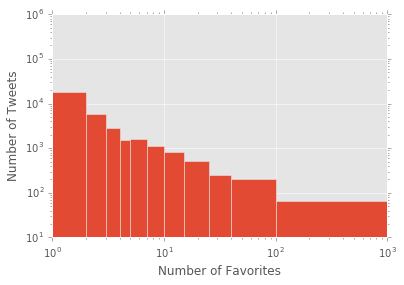

In [9]:
nums.favorite_count.hist(bins=[0,1,2,3,4,5,7,10,15,25,40,100,1000])
from matplotlib import pyplot as plt
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposy='clip')
plt.xlabel('Number of Favorites')
plt.ylabel('Number of Tweets')

When I first ran this, my dataframes weren't "aligned".  
So it's very important to check your datasets after every load.  
The correspondence between dates and topics and numerical features is critical for training!  

In [10]:
print(len(dates))
print(len(topics))
print(len(nums))
print(sum(nums.favorite_count >= 1))

183070
183070
183070
33292


In [11]:
sum(nums.index == dates.index) == len(dates)

True

In [12]:
sum(nums.index == topics.index) == len(dates)

True

In [13]:
sgd = SGDRegressor()
sgd

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [14]:
sgd = SGDRegressor().fit(topics.values, nums.favorite_count)

Well, that was **much** faster...

In [15]:
predicted_favorites = sgd.predict(topics.values)
predicted_favorites

array([ 0.9487,  0.8142,  0.8866, ..., -0.0416,  0.8142,  0.7132])

In [16]:
np.sum(predicted_favorites >= 1)

59998

Well that seems more "balanced" at least.  
And it's nice to have a continuous score.  

In [17]:
np.sum(nums.favorite_count.values >= 1)

33292

In [18]:
from pug.nlp.stats import Confusion

In [19]:
results = pd.DataFrame()
results['predicted'] = pd.Series(predicted_favorites >= 1)
results['truth'] = pd.Series(nums.favorite_count >= 1)
conf = Confusion(results)
conf

truth,False,True
predicted,,
False,110745,12327
True,39033,20965


In [20]:
results.predicted.corr(results.truth)

0.3033

Wait, why are we classifying with a regressor anyway?

In [21]:
pd.Series(predicted_favorites).corr(nums.favorite_count)

0.1000

## Not so hot...
Balance the training again?  
Get rid of some negatives?    

In [32]:
pos = np.array(nums.favorite_count >= 1)
neg = ~pos
portion_pos = 2 * float(sum(pos)) / len(nums)
mask = ((np.random.binomial(1, portion_pos, size=len(nums)).astype(bool) & neg) | pos)
sgd = SGDRegressor().fit(topics[mask], nums.favorite_count[mask] >= 1)
print(portion_pos)
print(sum(mask))
print(sum(pos) * 2)
print(sum(neg))
len(nums)

0.363707871306
87611
66584
149778


183070

In [33]:
results = pd.DataFrame()
# you have to adjust the threshold as you add more negatives
results['predicted'] = pd.Series(sgd.predict(topics.values) > .3)
results['truth'] = pd.Series(nums.favorite_count.values >= 1)
conf = Confusion(results)
conf

truth,False,True
predicted,,
False,76153,933
True,73625,32359


In [34]:
results.predicted.corr(results.truth)

0.3753

In [35]:
conf.stats_dict

PrettyDict([('tpr', 0.9879),
            ('fpr', 0.6947),
            ('tnr', 0.3053),
            ('fnr', 0.0121),
            ('plr', 1.4221),
            ('nlr', 0.0396),
            ('accuracy', 0.5927),
            ('sensitivity', 0.9879),
            ('specificity', 0.3053),
            ('mcc', 1.2217),
            ('chi_squared', 273238.0545)])

So once again about 38% correlation is the best we can do...  
  
Don't try this at home!  
It never finished after 10 hours of running on my laptop  

In [ ]:
svr = SVR().fit(topics.values, nums.favorite_count)

Prepare to wait for quite a while...  
Support vector machines are not efficient,  
but they can be **very** accurate.  
Unfortunately, gensim hasn't parallelized this model yet.  
Did I mention that **gensim is sprinting?**  